In [1]:
%matplotlib inline

# useful packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx
import time
import pandas as pd
from scipy.optimize import minimize

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit.quantum_info import Statevector
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere
import qiskit

In [3]:
# 3x3 non-peri accuracy
vqe = pd.read_excel('/Users/youfuqian/My Drive/College/#Research/3.MaxCut and statistical physics/VQE approach/Comprehensive Long run/SLSQP(2000)_D1 reps = 0.xlsx')
qaoa = pd.read_excel('3x3 data.xlsx')

In [4]:
vqe

,Unnamed: 0,seed,size,optimizer,state after 1st iteration,probability for the 1st state,energy for the 1st state,terminate iterations,energy,time (s),max cut objective,solution,solution objective
0,0,201,9,SLSQP(maxiter=2000),1010000,0.444,0.464235,142,-6.0,0.316483,-12.0,[1. 0. 1. 0. 1. 0. 1. 0. 1.],12
1,1,202,9,SLSQP(maxiter=2000),110011101,0.442,-1.170481,150,-6.0,0.305666,-12.0,[1. 0. 1. 0. 1. 0. 1. 0. 1.],12
2,2,203,9,SLSQP(maxiter=2000),100111011,0.320,0.498845,135,-6.0,0.295747,-12.0,[1. 0. 1. 0. 1. 0. 1. 0. 1.],12
3,3,204,9,SLSQP(maxiter=2000),10101010,0.565,-4.053462,80,-6.0,0.218018,-12.0,[0. 1. 0. 1. 0. 1. 0. 1. 0.],12
4,4,205,9,SLSQP(maxiter=2000),101110,0.275,-0.532491,105,-6.0,0.215631,-12.0,[0. 1. 0. 1. 0. 1. 0. 1. 0.],12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9795,9795,9996,9,SLSQP(maxiter=2000),101,0.430,1.108273,177,-6.0,0.364740,-12.0,[1. 0. 1. 0. 1. 0. 1. 0. 1.],12
9796,9796,9997,9,SLSQP(maxiter=2000),101100100,0.260,-0.031115,135,-6.0,0.283894,-12.0,[1. 0. 1. 0. 1. 0. 1. 0. 1.],12
9797,9797,9998,9,SLSQP(maxiter=2000),111010101,0.286,-0.648218,102,-6.0,0.241431,-12.0,[1. 0. 1. 0. 1. 0. 1. 0. 1.],12
9798,9798,9999,9,SLSQP(maxiter=2000),10011111,0.443,1.013826,141,-3.0,0.291485,-9.0,[0. 0. 1. 1. 1. 0. 0. 0. 1.],9


In [5]:
qaoa

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,seed,size,optimizer,time (s),solution,solution probability,max_cut objective
0,0,0,0,0,201,9,COBYLA,0.288472,101010101,72,-12
1,1,1,1,1,202,9,COBYLA,0.261900,101010101,52,-12
2,2,2,2,2,203,9,COBYLA,0.264544,101010101,63,-12
3,3,3,3,3,204,9,COBYLA,0.262619,101010101,67,-12
4,4,4,4,4,205,9,COBYLA,0.264326,101010101,52,-12
...,...,...,...,...,...,...,...,...,...,...,...
9795,9795,9795,9795,9795,9996,9,COBYLA,0.313541,10101010,56,-12
9796,9796,9796,9796,9796,9997,9,COBYLA,0.302649,10101010,79,-12
9797,9797,9797,9797,9797,9998,9,COBYLA,0.308498,10101010,57,-12
9798,9798,9798,9798,9798,9999,9,COBYLA,0.304797,101010101,63,-12


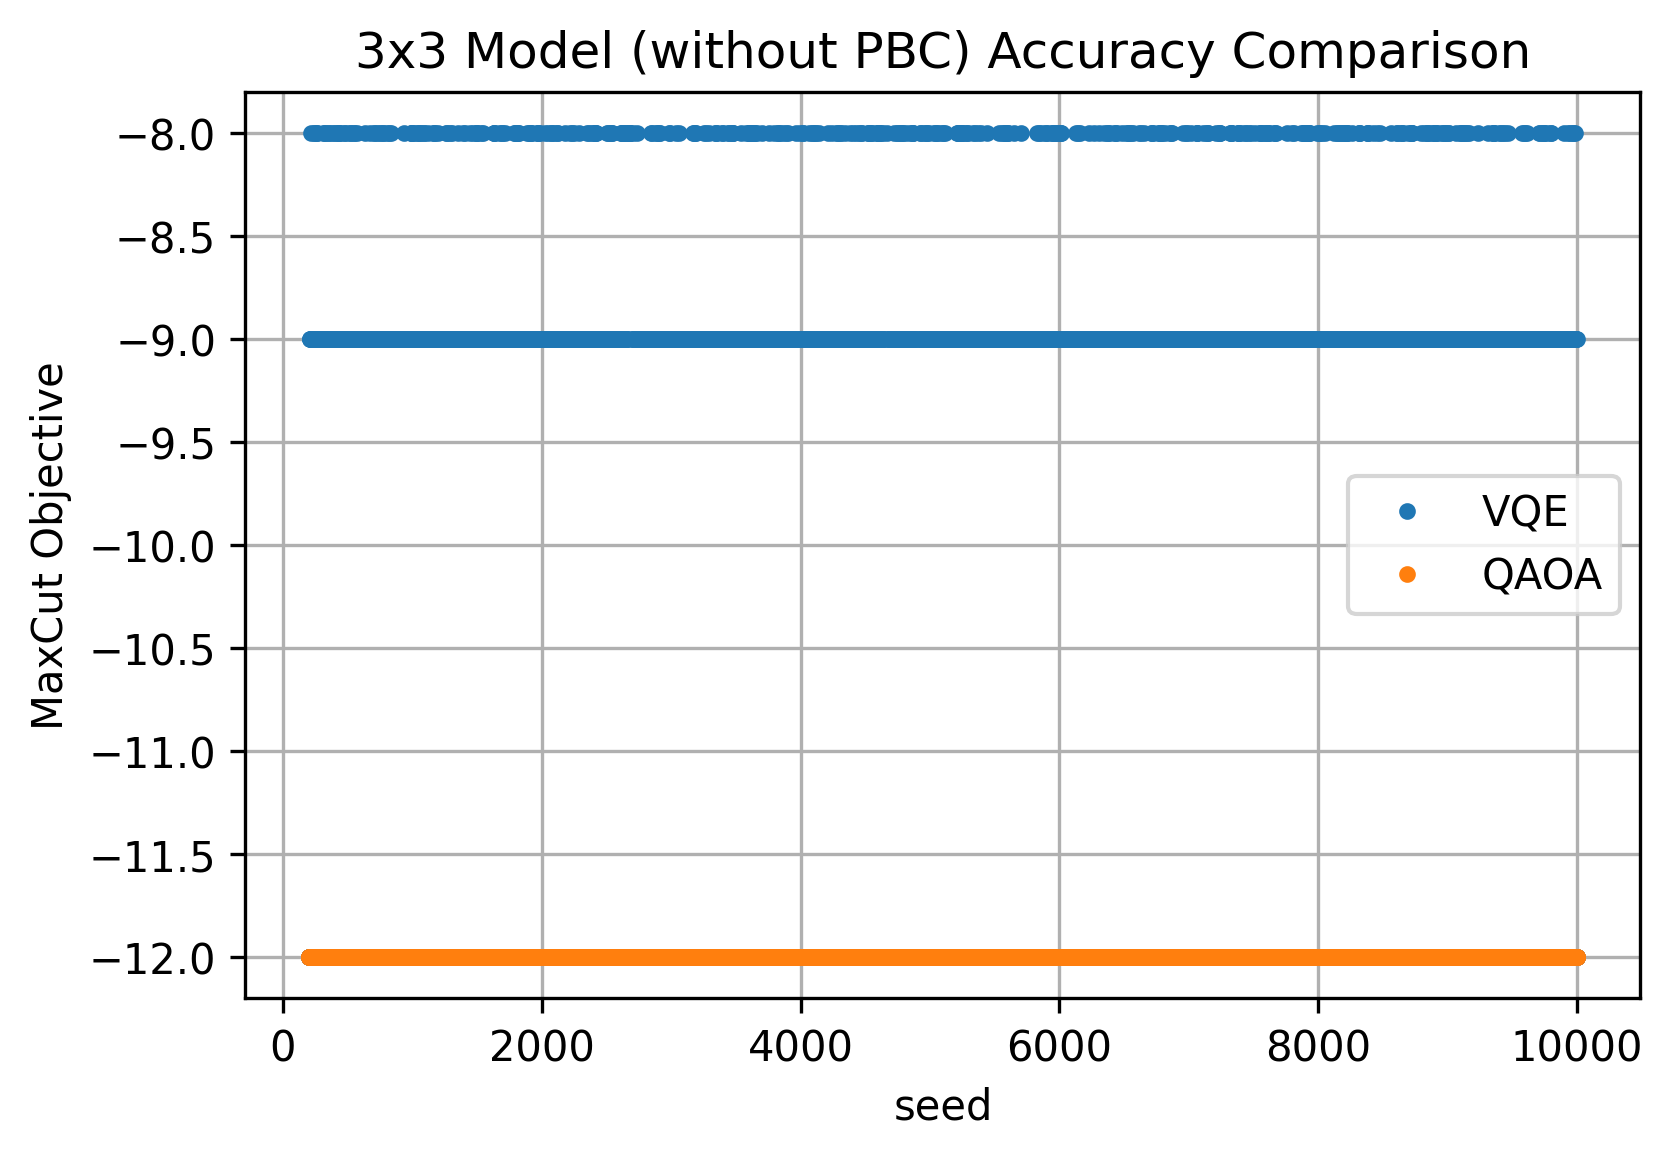

In [6]:
seed = np.linspace(201, 10000, 9800)

vqe_objective = vqe['max cut objective']
qaoa_objective = qaoa['max_cut objective']
plt.figure(dpi = 300)
plt.plot(seed, vqe_objective, '.', label = 'VQE')
plt.plot(seed, qaoa_objective, '.', label = 'QAOA')
plt.xlabel('seed')
plt.ylabel('MaxCut Objective')
plt.title('3x3 Model (without PBC) Accuracy Comparison')
plt.legend()
plt.grid()
plt.show()

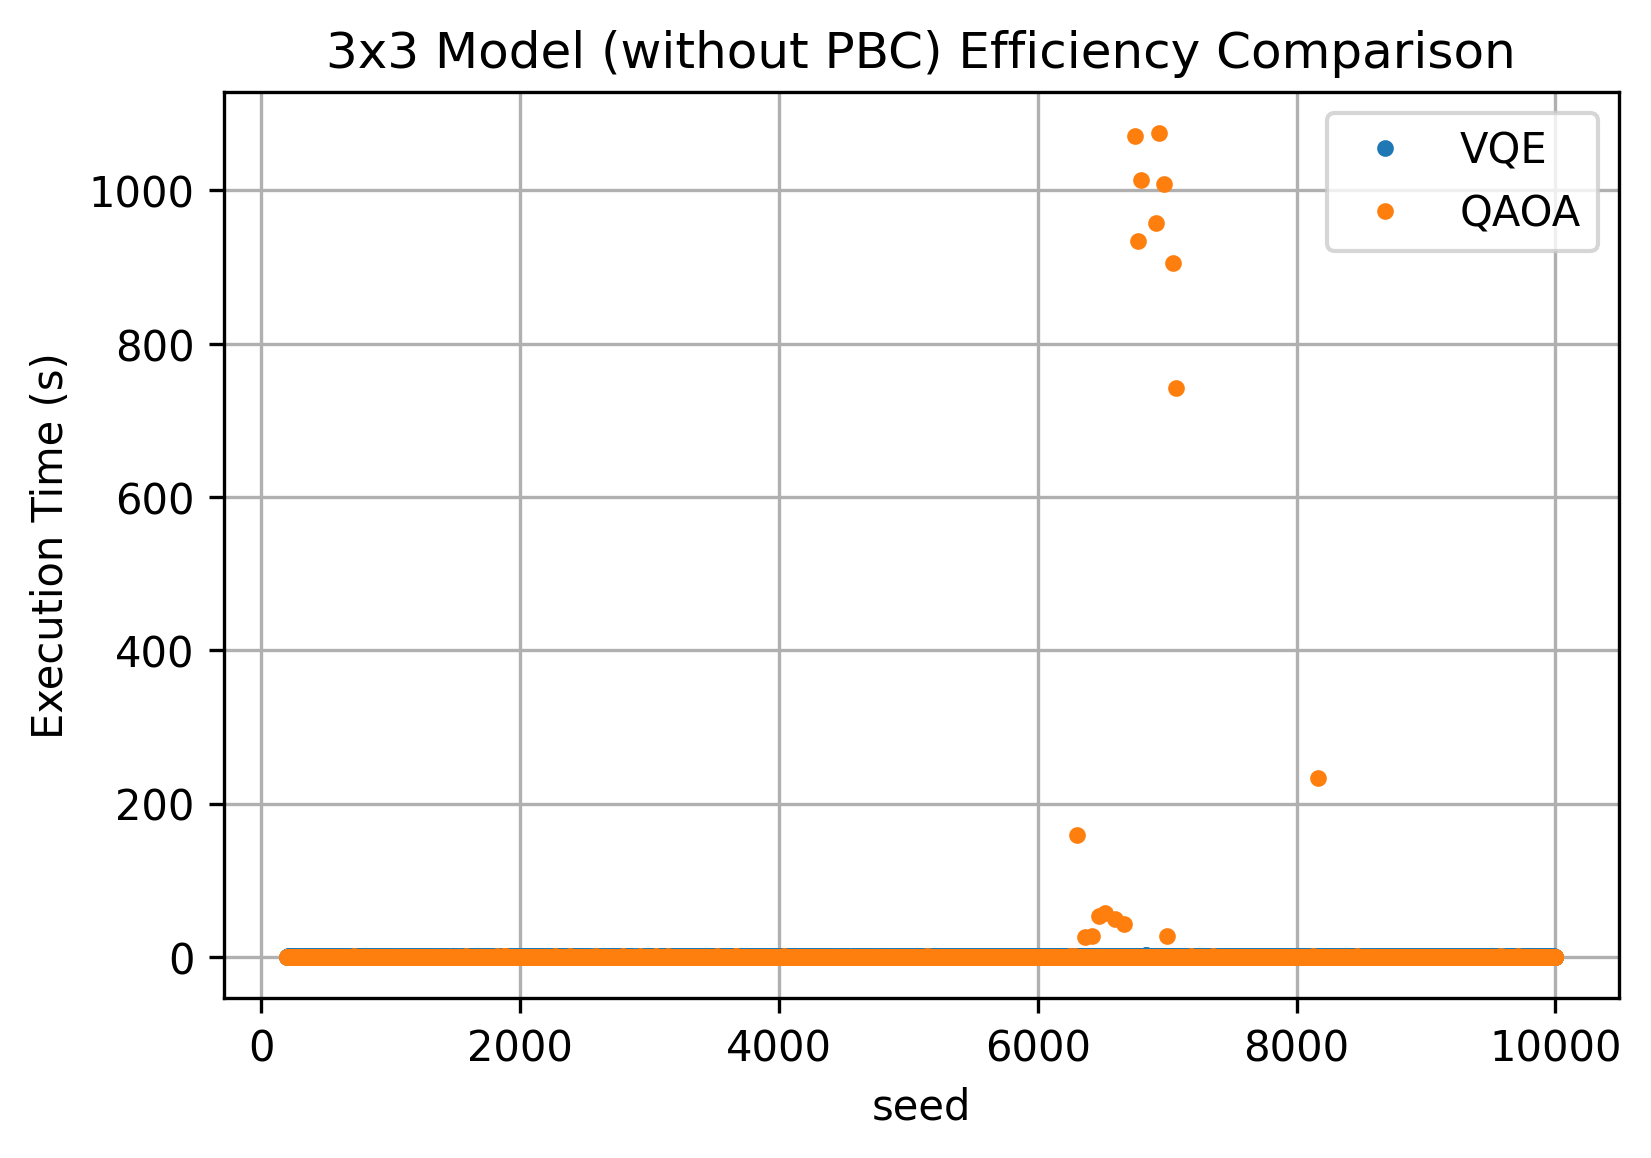

In [7]:
# 3x3 non-peri time
vqe_time = vqe['time (s)']
qaoa_time = qaoa['time (s)']
plt.figure(dpi = 300)
plt.plot(seed, vqe_time, '.', label = 'VQE')
plt.plot(seed, qaoa_time, '.', label = 'QAOA')
plt.xlabel('seed')
plt.ylabel('Execution Time (s)')
plt.title('3x3 Model (without PBC) Efficiency Comparison')
plt.legend()
plt.grid()
plt.show()

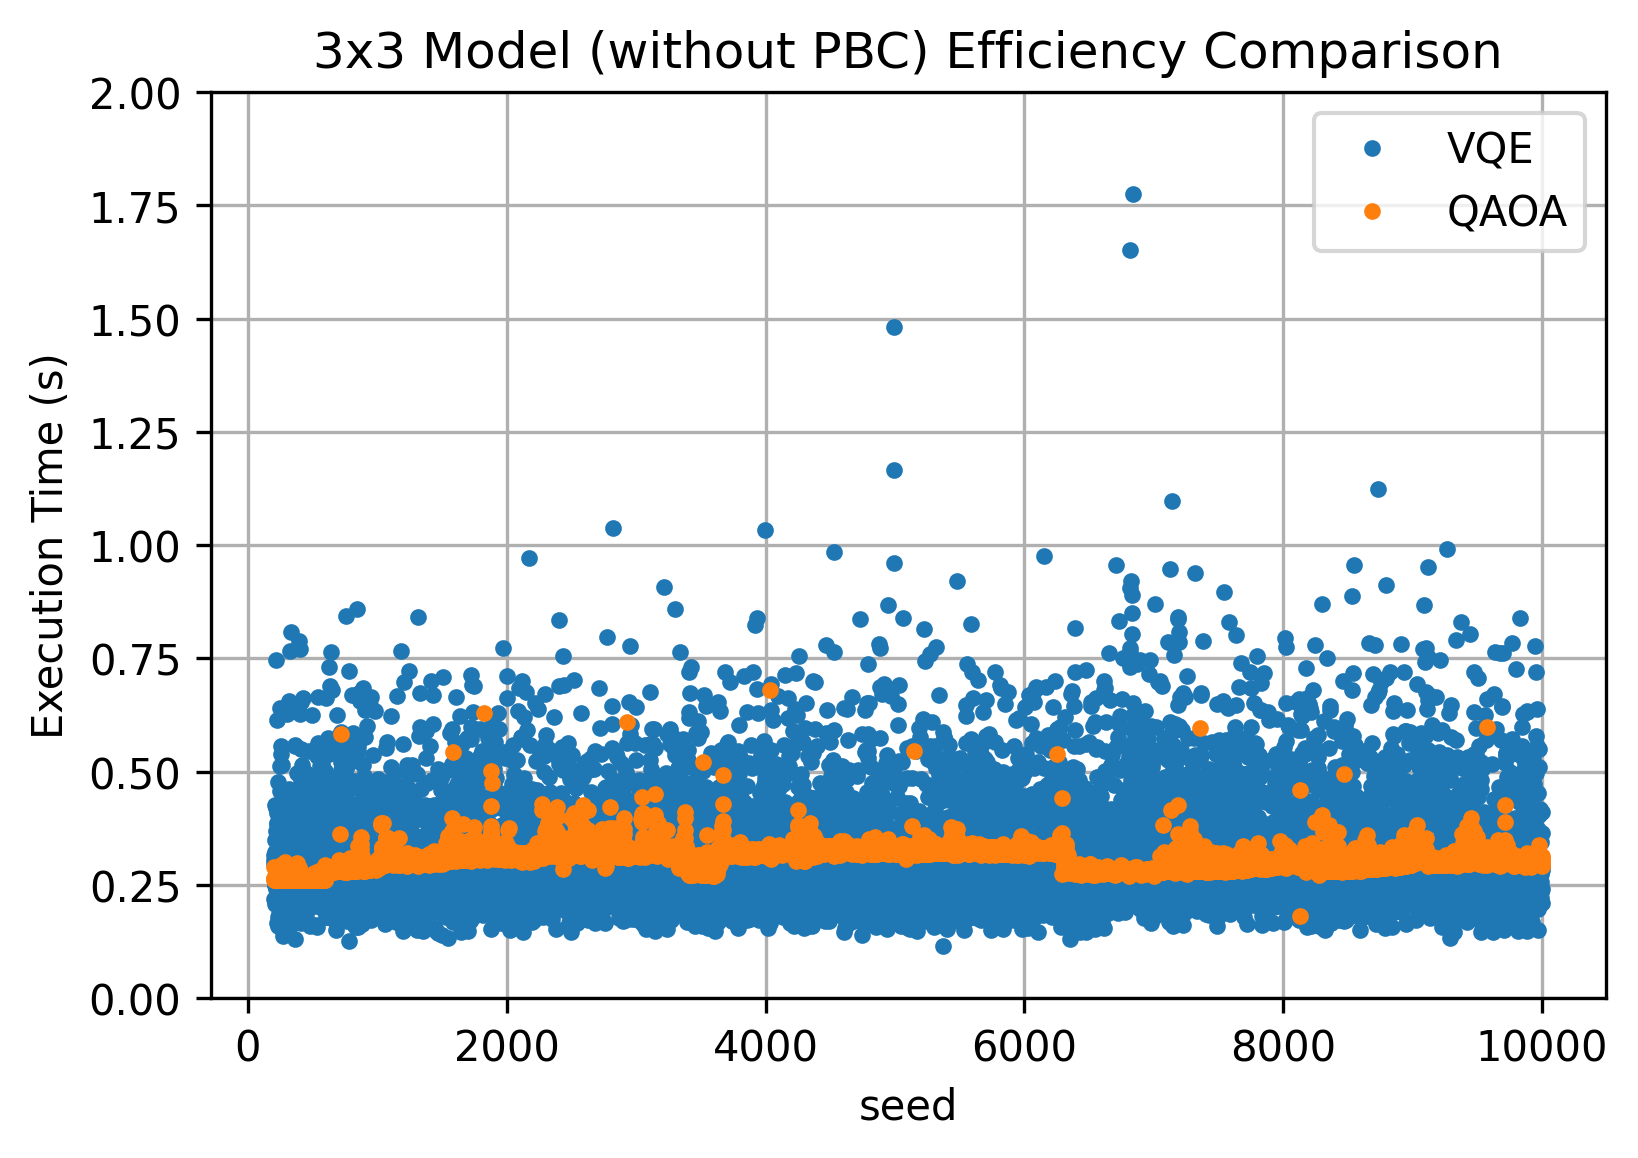

In [8]:
# 3x3 non-peri time
vqe_time = vqe['time (s)']
qaoa_time = qaoa['time (s)']
plt.figure(dpi = 300)
plt.plot(seed, vqe_time, '.', label = 'VQE')
plt.plot(seed, qaoa_time, '.', label = 'QAOA')
plt.xlabel('seed')
plt.ylabel('Execution Time (s)')
plt.title('3x3 Model (without PBC) Efficiency Comparison')
plt.legend()
plt.grid()
plt.ylim(bottom = 0, top = 2)
plt.show()

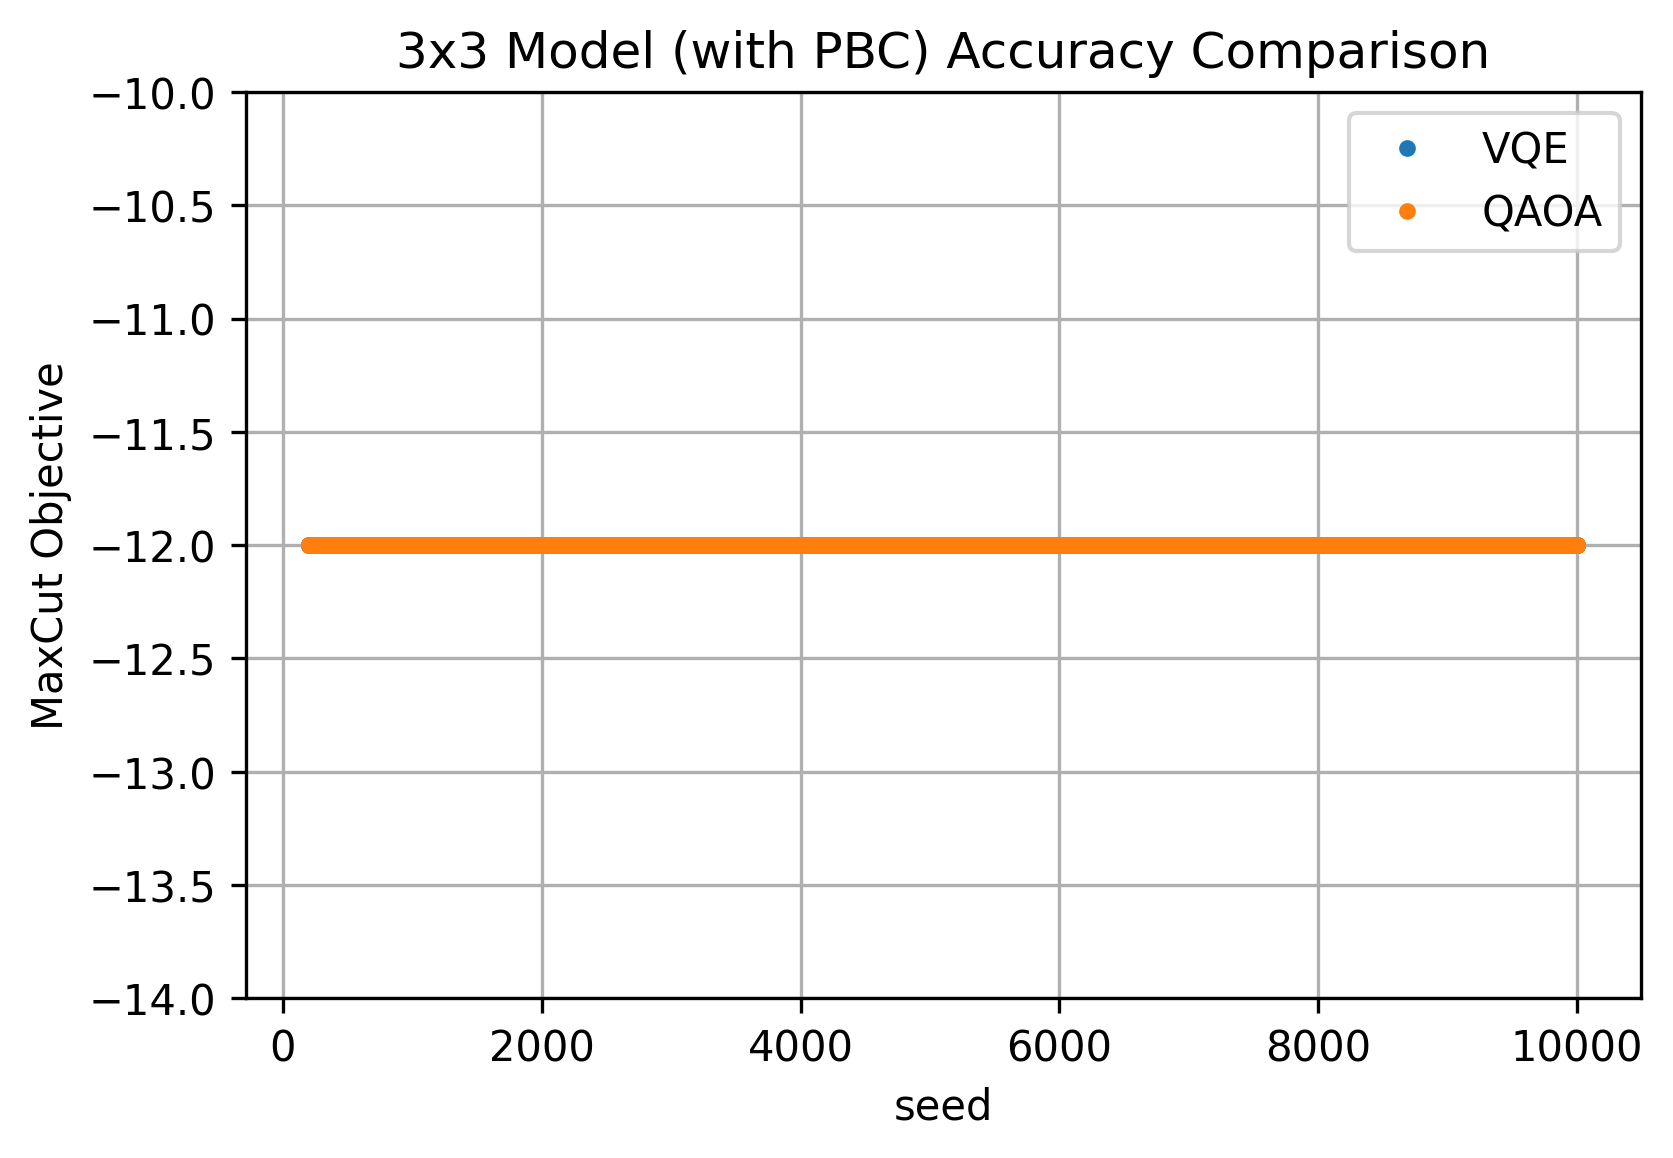

In [16]:
# 3x3 peri accuracy
vqe = pd.read_excel('/Users/youfuqian/My Drive/College/#Research/3.MaxCut and statistical physics/VQE approach/Periodic Boundary/3x3 periodic slsqp.xlsx')
qaoa = pd.read_excel('3x3 data periodic.xlsx')
vqe_objective = vqe['max cut objective']
qaoa_objective = qaoa['max_cut objective']
plt.figure(dpi = 300)
plt.plot(seed, vqe_objective, '.', label = 'VQE')
plt.plot(seed, qaoa_objective, '.', label = 'QAOA')
plt.xlabel('seed')
plt.ylabel('MaxCut Objective')
plt.title('3x3 Model (with PBC) Accuracy Comparison')
plt.legend()
plt.grid()
plt.ylim(bottom = -14, top = -10)
plt.show()

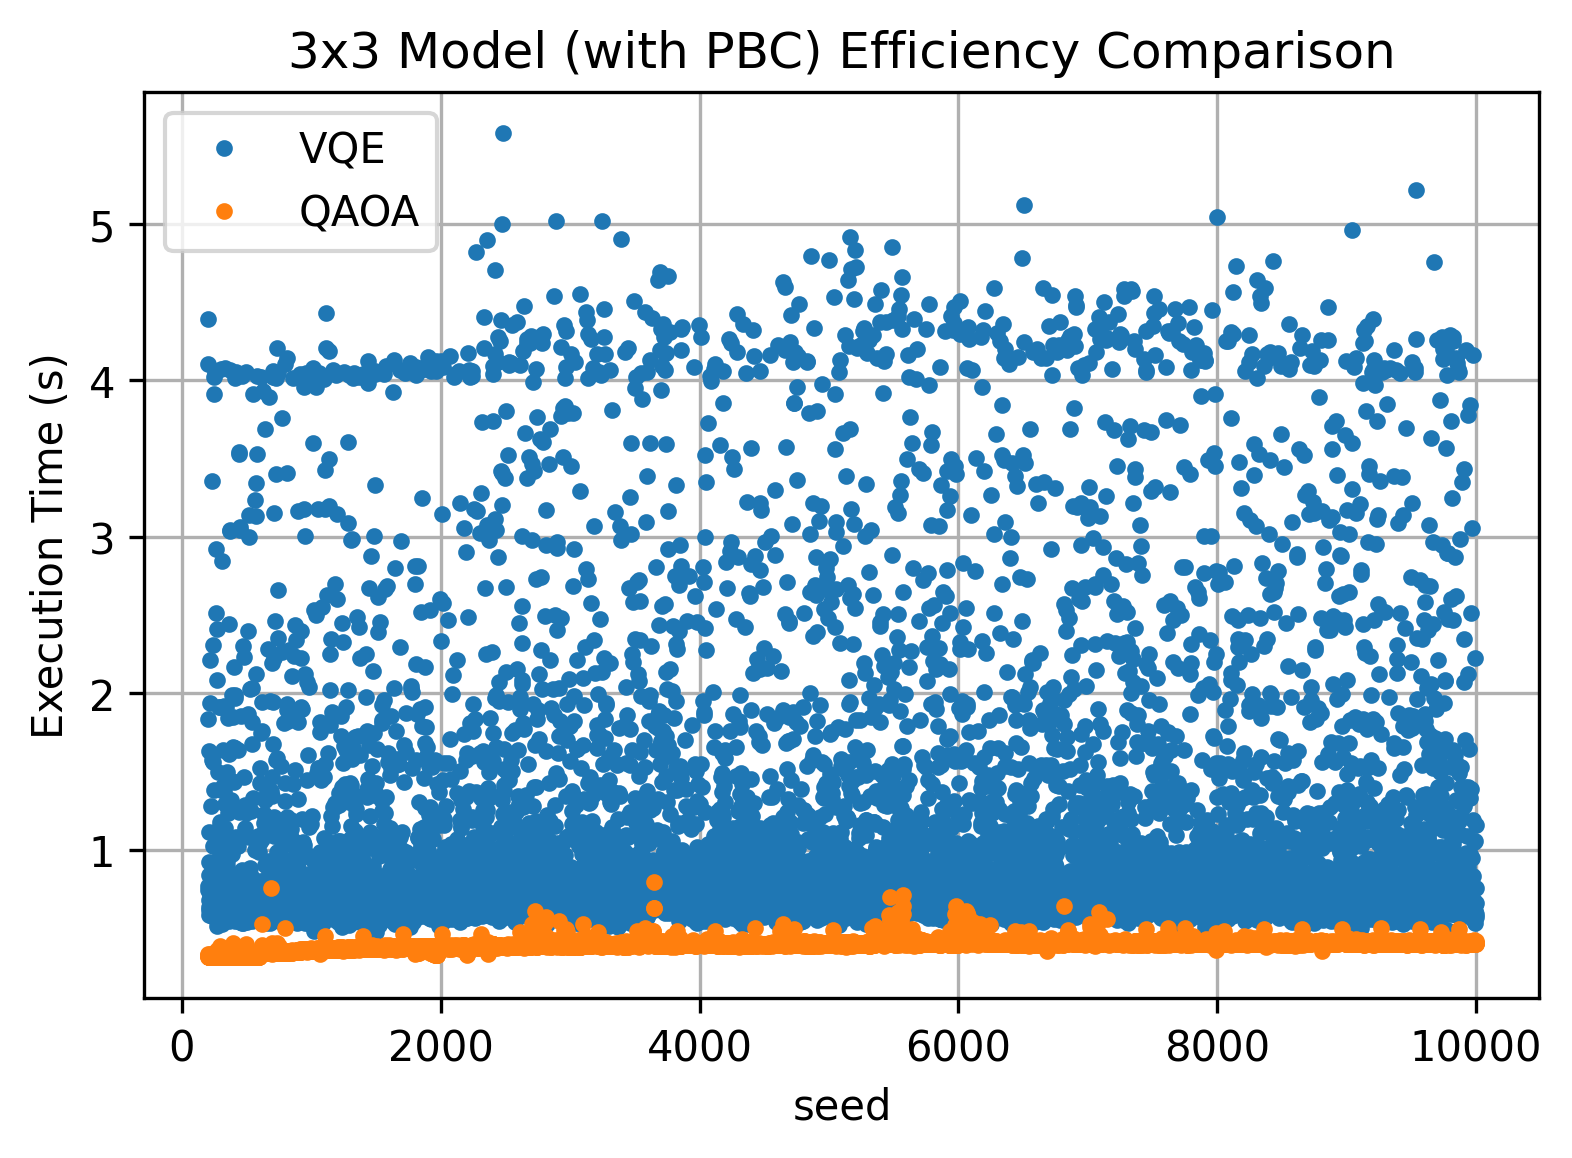

In [17]:
# 3x3 non-peri time
vqe_time = vqe['time (s)']
qaoa_time = qaoa['time (s)']
plt.figure(dpi = 300)
plt.plot(seed, vqe_time, '.', label = 'VQE')
plt.plot(seed, qaoa_time, '.', label = 'QAOA')
plt.xlabel('seed')
plt.ylabel('Execution Time (s)')
plt.title('3x3 Model (with PBC) Efficiency Comparison')
plt.legend()
plt.grid()
plt.show()

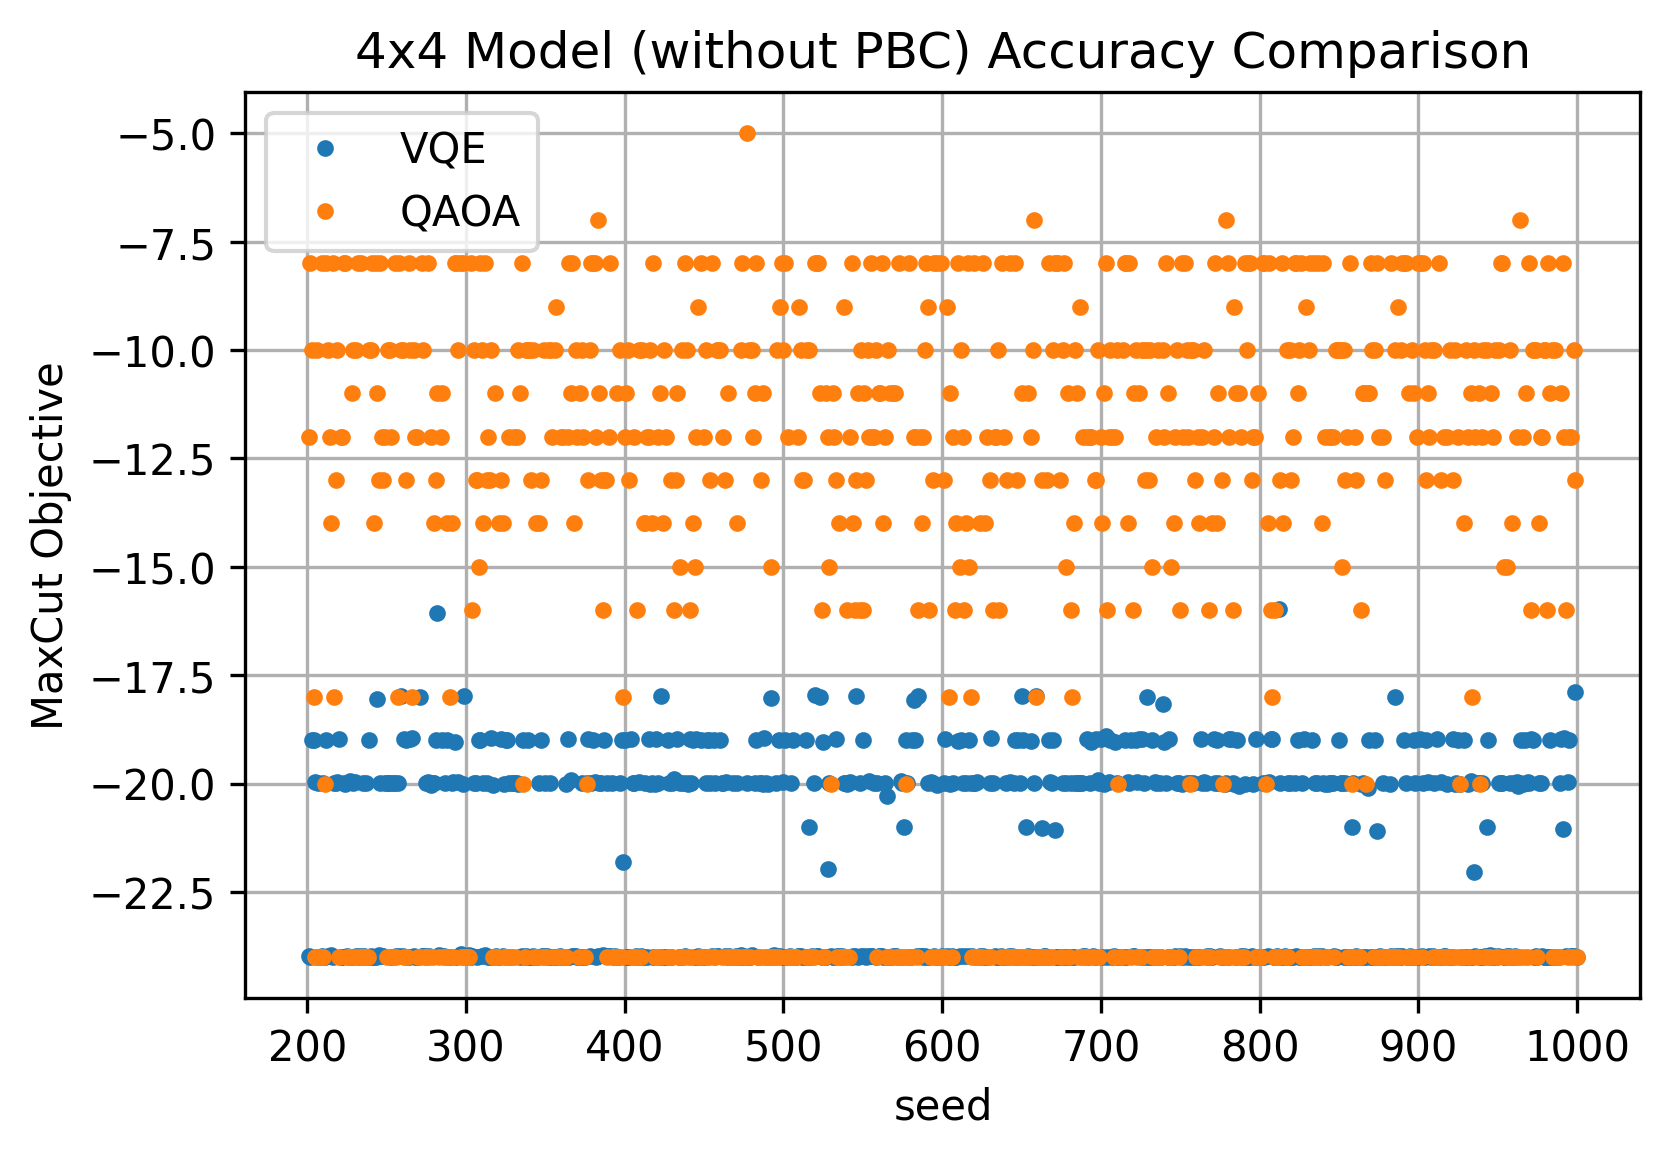

In [22]:
# 4x4 non-peri accuracy
seed = np.linspace(201, 1000, 800)
vqe = pd.read_excel('/Users/youfuqian/My Drive/College/#Research/3.MaxCut and statistical physics/VQE approach/Greater size/4x4 qasm.xlsx')
qaoa = pd.read_excel('4x4 data.xlsx')
vqe_objective = vqe['max cut objective']
qaoa_objective = qaoa['max_cut objective'][:800]
plt.figure(dpi = 300)
plt.plot(seed, vqe_objective, '.', label = 'VQE')
plt.plot(seed, qaoa_objective, '.', label = 'QAOA')
plt.xlabel('seed')
plt.ylabel('MaxCut Objective')
plt.title('4x4 Model (without PBC) Accuracy Comparison')
plt.legend()
plt.grid()
# plt.ylim(bottom = -14, top = -10)
plt.show()

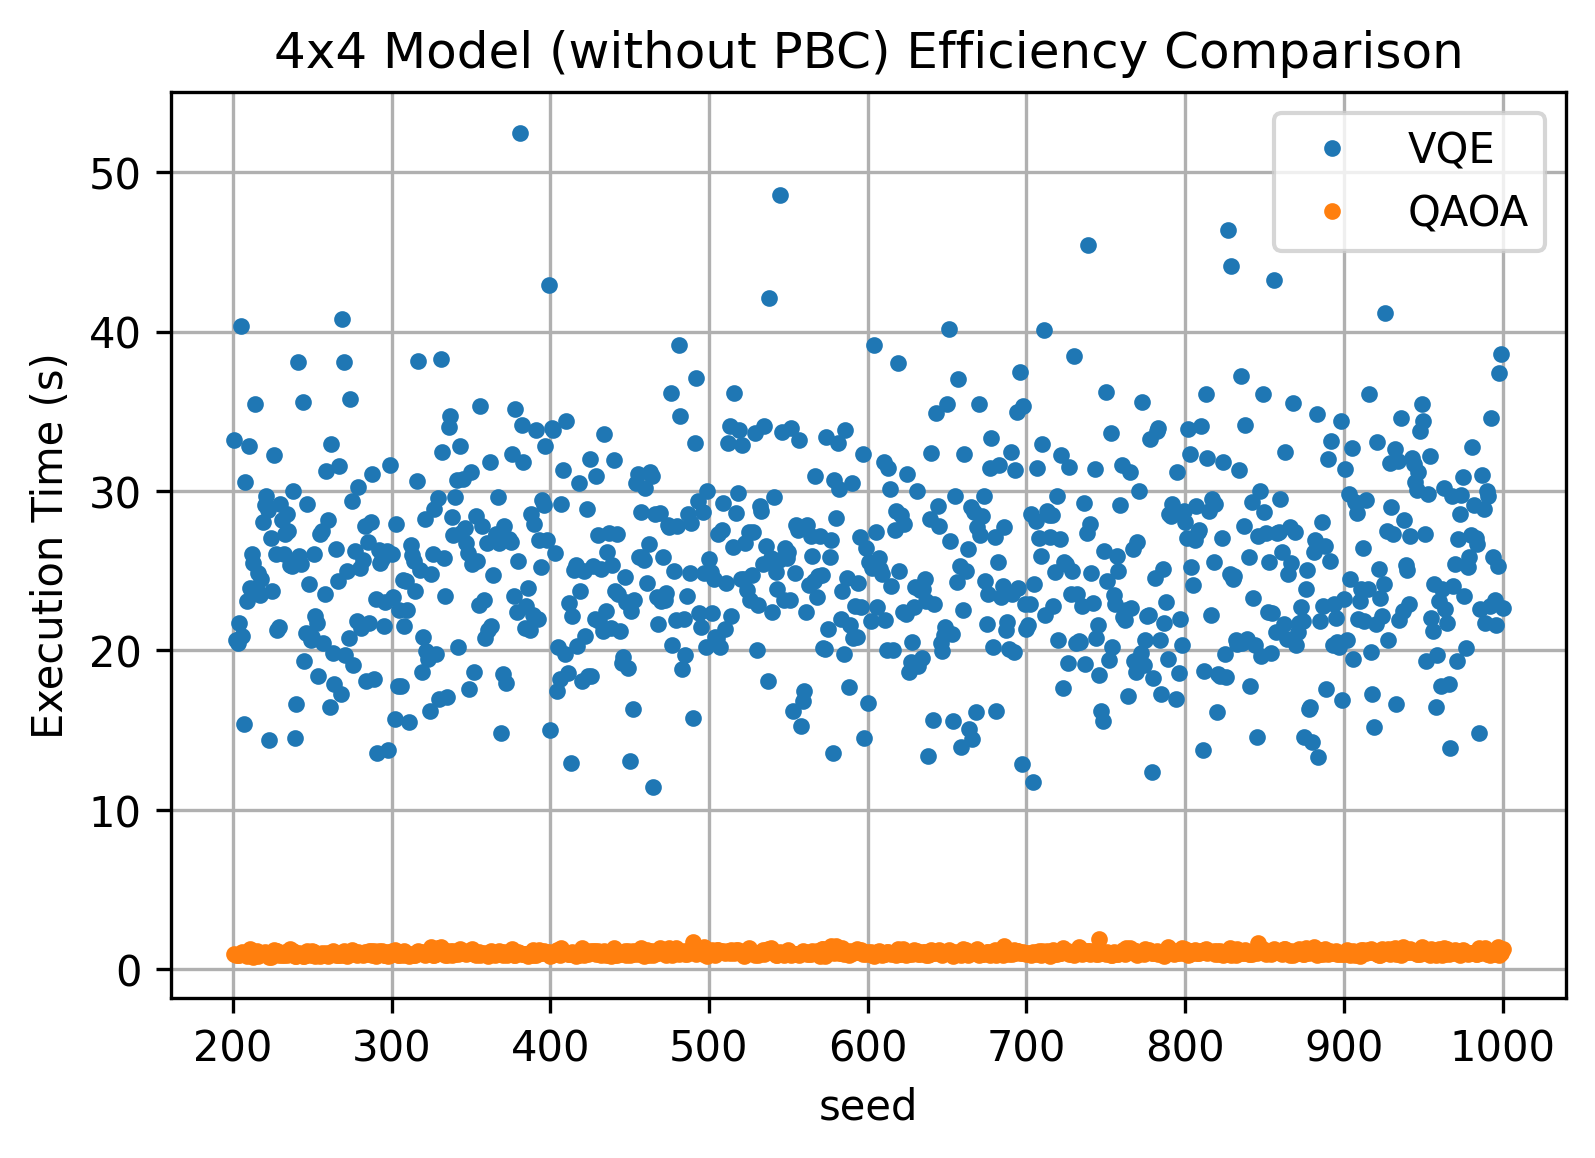

In [24]:
# 4x4 non-peri time
vqe_time = vqe['time (s)']
qaoa_time = qaoa['time (s)'][:800]
plt.figure(dpi = 300)
plt.plot(seed, vqe_time, '.', label = 'VQE')
plt.plot(seed, qaoa_time, '.', label = 'QAOA')
plt.xlabel('seed')
plt.ylabel('Execution Time (s)')
plt.title('4x4 Model (without PBC) Efficiency Comparison')
plt.legend()
plt.grid()
plt.show()

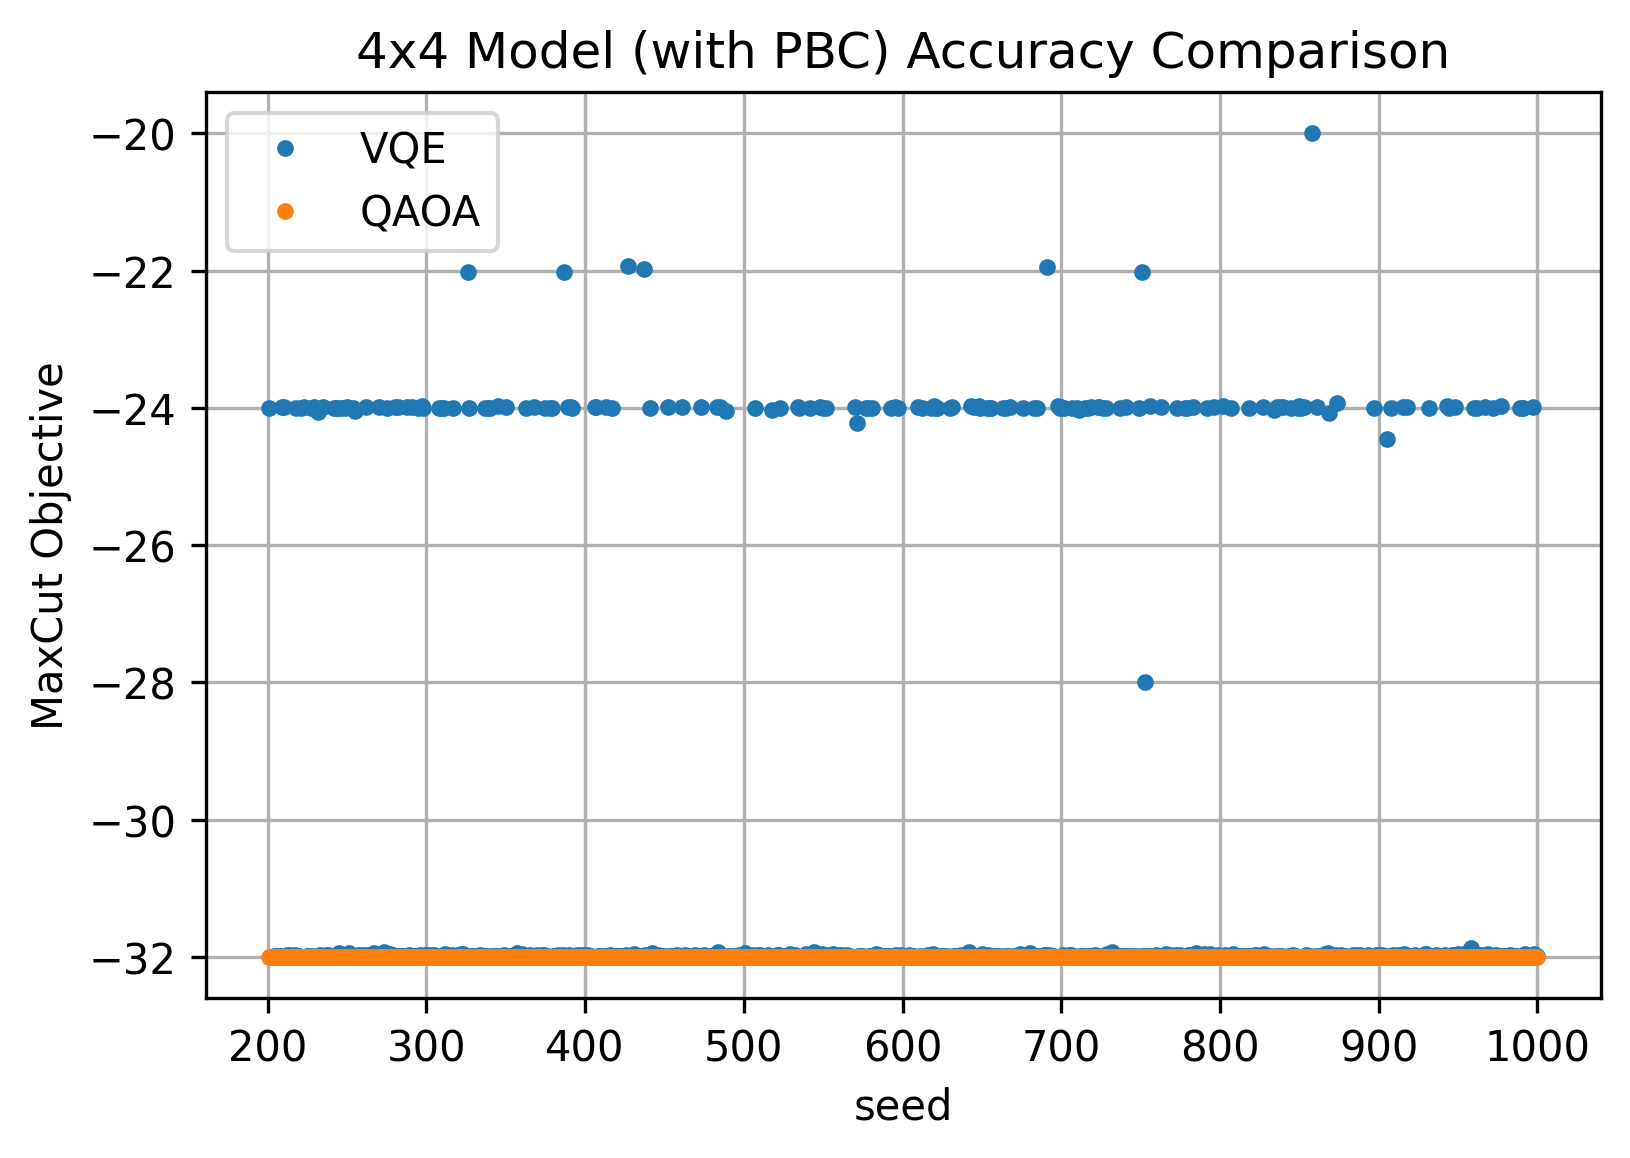

In [26]:
# 4x4 peri accuracy
seed = np.linspace(201, 1000, 800)
vqe = pd.read_excel('/Users/youfuqian/My Drive/College/#Research/3.MaxCut and statistical physics/VQE approach/Greater size/4x4 periodic.xlsx')
qaoa = pd.read_excel('4x4 data periodic.xlsx')
vqe_objective = vqe['max cut objective']
qaoa_objective = qaoa['max_cut objective'][:800]
plt.figure(dpi = 300)
plt.plot(seed, vqe_objective, '.', label = 'VQE')
plt.plot(seed, qaoa_objective, '.', label = 'QAOA')
plt.xlabel('seed')
plt.ylabel('MaxCut Objective')
plt.title('4x4 Model (with PBC) Accuracy Comparison')
plt.legend()
plt.grid()
# plt.ylim(bottom = -14, top = -10)
plt.show()

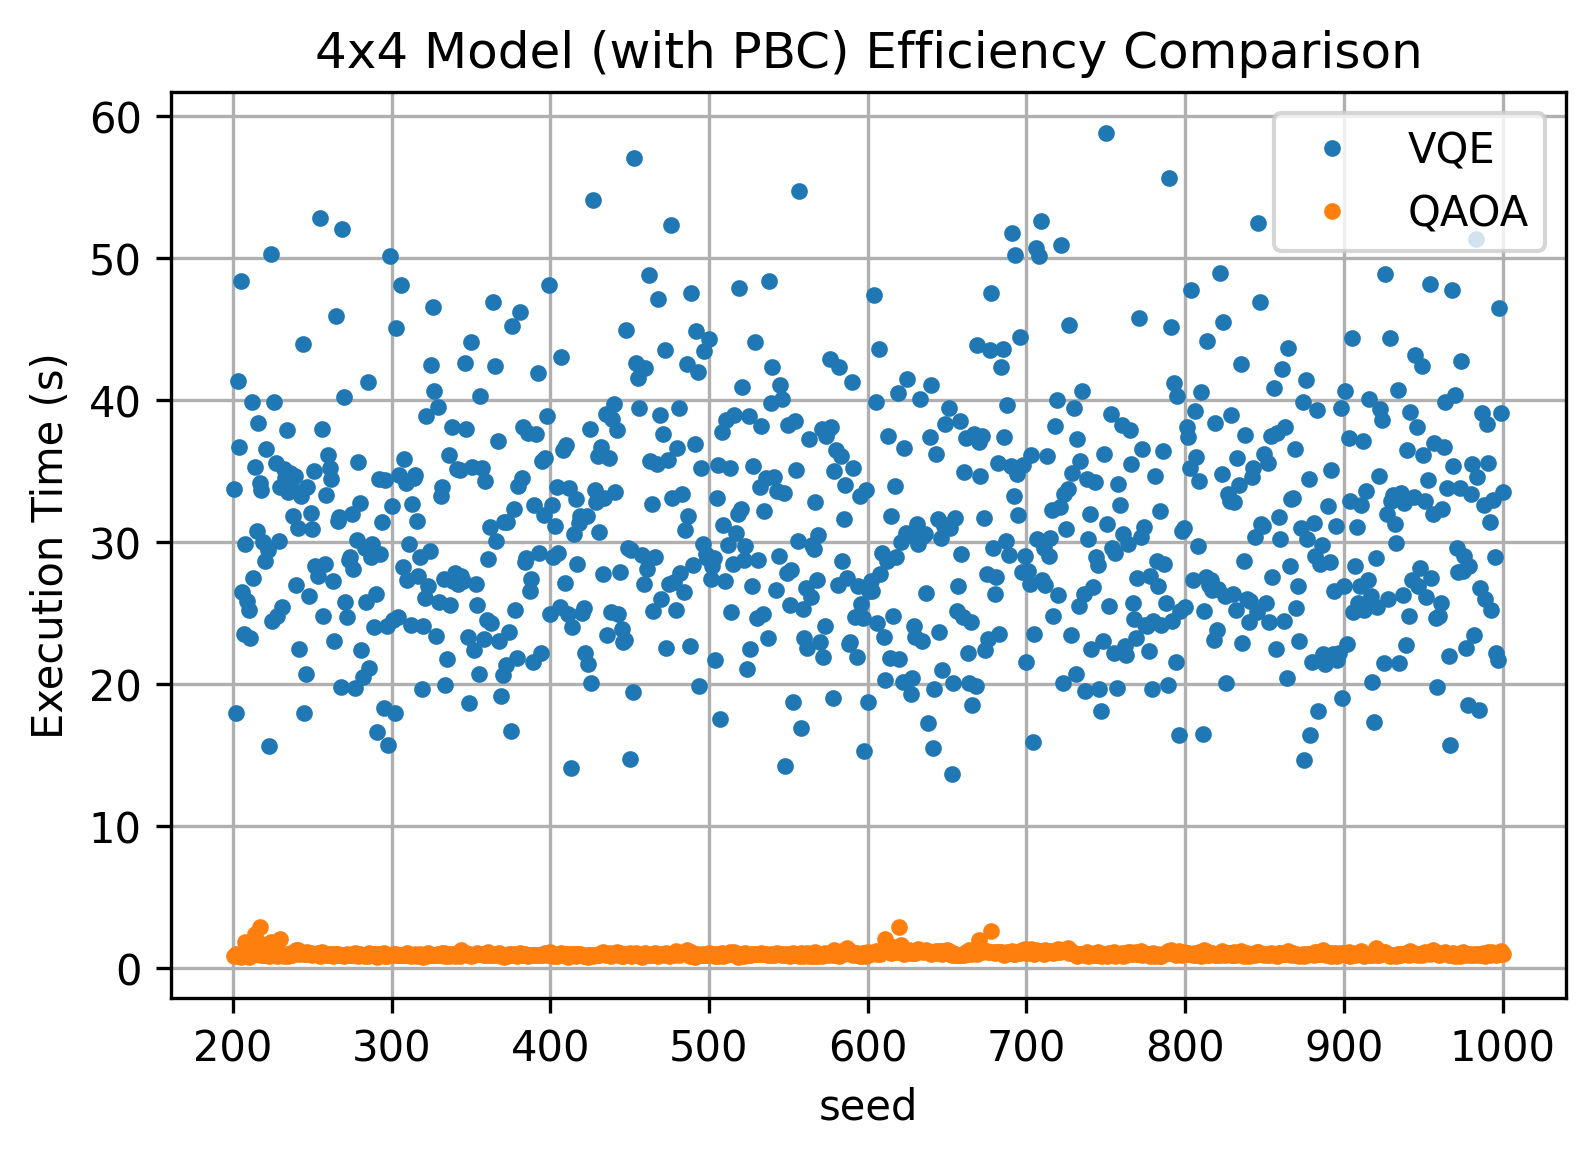

In [27]:
# 4x4 non-peri time
vqe_time = vqe['time (s)']
qaoa_time = qaoa['time (s)'][:800]
plt.figure(dpi = 300)
plt.plot(seed, vqe_time, '.', label = 'VQE')
plt.plot(seed, qaoa_time, '.', label = 'QAOA')
plt.xlabel('seed')
plt.ylabel('Execution Time (s)')
plt.title('4x4 Model (with PBC) Efficiency Comparison')
plt.legend()
plt.grid()
plt.show()